In [1]:
import sys
sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### このファイルでは、Hellyモデルで基本図を書くことを目的とする。



In [2]:
TOTAL_TIME = 50
time_step = 0.5
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 50
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい

print(f"この設定だと法定速度は時速{real_legal_speed}km")
print(f"巡航距離は{TOTAL_DISTANCE * scale_factor /1000}kmです")

この設定だと法定速度は時速108.0km
巡航距離は1.0kmです


In [3]:
DRONE_NUM = 20
v_0 = 0
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_brake_acc = 0.8
rear_brake_acc = 0.4
response_time = 0.5
d = 0.5
print(min_acc, max_acc)

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake":front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":response_time,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": d,
    "T_des": 1,
    "isRss":True
  }

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, should_scatter=False):
    delta = total_distance / car_num
    return total_distance - delta * (idx+1)
    

cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=helly_params,
                     )
               for i in range(DRONE_NUM)]
print("最大加速度は{:.2f}G".format(MAX_ACC_REAL_WORLD / 9.8))
print("最小加速度は{:.2f}G".format(MIN_ACC_REAL_WORLD / 9.8))
print("平均車間距離は{:.2f}m".format(TOTAL_DISTANCE / DRONE_NUM * scale_factor))

0.25 0.1
最大加速度は0.20G
最小加速度は0.51G
平均車間距離は50.00m


In [4]:
simulation = SimulationPeriodic(
    TOTAL_TIME=TOTAL_TIME, 
    time_step=time_step, 
    scale_factor=scale_factor,
    drone_list=cars_list,
    TOTAL_DISTANCE=TOTAL_DISTANCE,
    UPDATE_RULE=UPDATE_RULE )

In [5]:
simulation.run()


===PARALLEL実行===
FINISHED


In [6]:
mean_distance = TOTAL_DISTANCE / DRONE_NUM
k1 = (1 / rear_brake_acc - 1 / front_brake_acc) * 1/2
k2 = response_time * (1 + max_acc / rear_brake_acc )
k3 = max_acc*response_time**2 / 2 * (1+max_acc / rear_brake_acc) + d - mean_distance
v = ((k2 ** 2 - 4*k1*k3)**(1/2) - k2 ) / 2 /k1
print(k1, k2, k3)
print(v)
print(mean_distance)

print("======")
print(k1 * v**2 + k2*v + k3)

print("============")
rho_delay = helly_params.get("response_time", 0.5)
min_comfortable_accel = helly_params.get("rear_brake_acc", min_acc*0.5)
front_car_brake = helly_params.get("front_car_brake", min_acc)
proceeding_speed = v
front_car_brake_distance = proceeding_speed**2 / front_car_brake / 2
brake_distance = (v + max_acc*rho_delay)**2/(min_comfortable_accel)/2
idle_distance = v * rho_delay + max_acc * rho_delay**2 / 2

print("my speed:", v)
print("a_max:", max_acc)
print(min_comfortable_accel)
print("proceeding_speed:", proceeding_speed)
print("front_car_brake_distance:", front_car_brake_distance)
print("brake_distance:", brake_distance)
print("idle_distance:", idle_distance)
print(d + brake_distance + idle_distance - front_car_brake_distance)

0.625 0.625 -1.984375
1.3506755523321747
2.5
0.0
my speed: 1.3506755523321747
a_max: 0.1
0.4
proceeding_speed: 1.3506755523321747
front_car_brake_distance: 1.1402027797923908
brake_distance: 2.4523650036263036
idle_distance: 0.6878377761660873
2.5


20
[42.5, 42.525, 42.574999999999996, 42.65, 42.75, 42.875, 43.025, 43.199999999999996, 43.4, 43.625, 43.875, 44.15, 44.449999999999996, 44.775, 45.125, 45.5, 45.9, 46.324999999999996, 46.775, 47.25, 47.75, 48.275, 48.824999999999996, 49.4, 0.0, 0.6210639745679956, 1.2567936023811654, 1.9029711713448947, 2.5567792165629015, 3.2162644696729075, 3.8800156272318986, 4.5469802655743194, 5.216359919078023, 5.887545643853578, 6.560074167127802, 7.2335952144241915, 7.907845872394276, 8.5826301447062, 9.257802726936717, 9.933256307125717]
101
[0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000002, 1.0500000000000003, 1.1000000000000003, 1.1500000000000004, 1.2000000000000004, 1.2421279491359893, 1.2714592556263329, 1.292355137927462, 1.3076160904360072, 1.318970

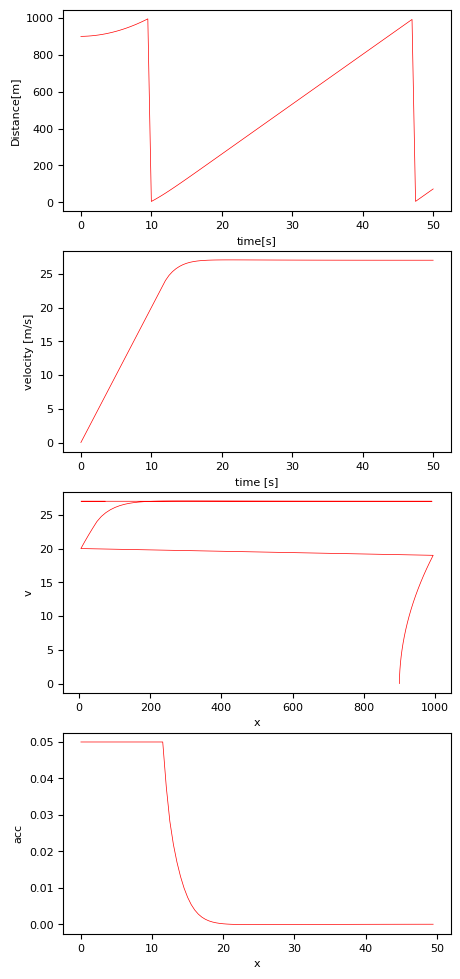

In [7]:
print(len(simulation.drone_list))
print((simulation.drone_list[2].xcorList[:40]))
print(len(simulation.drone_list[2].xcorList))
print((simulation.drone_list[2].v_xList))
drone_1 = simulation.drone_list[1]
drone_1.plot_history_scaled(time_step, scale_factor)

In [8]:
print("ここから動画を作る")

ここから動画を作る


In [10]:
import cv2
import os

color_list=["orange","pink","blue","brown","red","green"]
images = []
frames = simulation.simulation_steps
drones = simulation.drone_list

radius = 4


for i in range(frames):
    if (i%4 ==1):
        continue
    plt.figure(figsize=(4,4))
    for (droneNum, drone) in enumerate(drones):
        theta = drone.xcorList[int(i)] /TOTAL_DISTANCE * 2 * np.pi
        if (droneNum == 0):
            plt.scatter(radius *np.cos(theta), radius * np.sin(theta), color=color_list[droneNum%6], s=6)
        else:
            plt.scatter(radius * np.cos(theta), radius * np.sin(theta), color=color_list[droneNum%6], s=6)
    plt.xlim(-1*(radius + 1 ) , radius + 1 )
    plt.ylim(-1*(radius + 1 ) , radius + 1 )
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    # plt.xlabel("Distance", fontsize=8)
    # plt.ylabel("Height", fontsize=8)
    plt.savefig(f"tmp/frame_{i}.png")
    plt.close()

    filename = 'tmp/frame_{}.png'.format(i)
    img = cv2.imread(filename)
    images.append(img)
    os.remove(f"tmp/frame_{i}.png")
    if (i%100 == 0):
        print(f"frame_{i}__Done")

print("動画作成開始")
output_file = f'tmp/output_circular_DroneNum={DRONE_NUM}_RSS.mp4'
fps = 10
size = (images[0].shape[1], images[0].shape[0])

# 動画を保存するためのオブジェクトを生成する
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, size)

# 100枚の画像を動画に書き込む
for i in range(len(images)):
    out.write(images[i])

# 動画を保存するための処理を終了する
out.release()
print("END")

ImportError: libGL.so.1: cannot open shared object file: No such file or directory